In [1]:
import numpy as np
import argparse
import sys
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import np_utils
from keras import backend as K

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# limit GPU memory use
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = "0" #only the gpu 0 is allowed
#set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
SOURCE_IMG_WIDTH = 80
SOURCE_IMG_HEIGHT = 80

datapath = 'D:\\FontImageGenerator\\TextImageGenerator\\TextImageGenerator\\bin\\Release\\Output\\'

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
train_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.5, width_shift_range=0.0, 
                                   height_shift_range=0.00, preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="wrap", 
                                   data_format='channels_last')

valid_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.5, width_shift_range=0.0, 
                                   height_shift_range=0.00, preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="wrap", 
                                   data_format='channels_last')

test_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.5, width_shift_range=0.0, 
                                   height_shift_range=0.00, preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="wrap", 
                                   data_format='channels_last')

train_generator = train_datagen.flow_from_directory(
    directory=datapath + 'Train\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb", #rgb
    batch_size=150,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_generator = valid_datagen.flow_from_directory(
    directory=datapath + 'Validate\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=150,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=datapath + 'Test\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

num_classes = len(valid_generator.class_indices)

Found 242900 images belonging to 347 classes.
Found 69400 images belonging to 347 classes.
Found 34700 images belonging to 1 classes.


In [4]:
#Load the VGG model
vgg_conv = VGG19(weights=None, include_top=False, input_shape=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = True
    
#vgg_conv.summary()

# Check the trainable status of the individual layers
#for layer in vgg_conv.layers:
#    print(layer, layer.trainable)

In [5]:
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(2048, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes, activation='softmax'))
#model.add(layers.Dense(num_classes, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
#
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-4),
              #optimizer=optimizers.Adadelta(lr=1),
              #optimizer=optimizers.Nadam(lr=2e-4),              
              #optimizer=optimizers.Adamax(lr=2e-4),              
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, min_delta = 0.001)
mc = ModelCheckpoint('all_freezed_vgg19_tf115_best.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 347)               711003    
Total params: 21,786,011
Trainable params: 21,786,011
Non-trainable params: 0
_________________________________________________________________


In [6]:
# initialize the number of epochs and batch size
EPOCHS = 200

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history_pre = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks=[es, mc, lr]
)

# Save the Model
model.save('all_freezed_vgg19_tf115.h5')

model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

Epoch 1/200
1619/1619 [==============================] - 527s 325ms/step - loss: 6.0604 - acc: 0.0124 - val_loss: 4.5588 - val_acc: 0.0358

Epoch 00001: val_acc improved from -inf to 0.03576, saving model to all_freezed_vgg19_tf18_best.h5
Epoch 2/200
1619/1619 [==============================] - 420s 259ms/step - loss: 4.0020 - acc: 0.0800 - val_loss: 3.4719 - val_acc: 0.1345

Epoch 00002: val_acc improved from 0.03576 to 0.13445, saving model to all_freezed_vgg19_tf18_best.h5
Epoch 3/200
1619/1619 [==============================] - 415s 257ms/step - loss: 3.0525 - acc: 0.1946 - val_loss: 2.6750 - val_acc: 0.2616

Epoch 00003: val_acc improved from 0.13445 to 0.26165, saving model to all_freezed_vgg19_tf18_best.h5
Epoch 4/200
1619/1619 [==============================] - 415s 257ms/step - loss: 2.5083 - acc: 0.2965 - val_loss: 2.3057 - val_acc: 0.3420

Epoch 00004: val_acc improved from 0.26165 to 0.34196, saving model to all_freezed_vgg19_tf18_best.h5
Epoch 5/200
1619/1619 [============

1619/1619 [==============================] - 419s 259ms/step - loss: 0.2523 - acc: 0.9016 - val_loss: 0.4494 - val_acc: 0.8446

Epoch 00036: val_acc improved from 0.83845 to 0.84465, saving model to all_freezed_vgg19_tf18_best.h5
Epoch 37/200
1619/1619 [==============================] - 419s 259ms/step - loss: 0.2462 - acc: 0.9032 - val_loss: 0.4533 - val_acc: 0.8433

Epoch 00037: val_acc did not improve from 0.84465
Epoch 38/200
1619/1619 [==============================] - 420s 259ms/step - loss: 0.2407 - acc: 0.9043 - val_loss: 0.4536 - val_acc: 0.8457

Epoch 00038: val_acc improved from 0.84465 to 0.84569, saving model to all_freezed_vgg19_tf18_best.h5
Epoch 39/200
1619/1619 [==============================] - 418s 258ms/step - loss: 0.2373 - acc: 0.9062 - val_loss: 0.4550 - val_acc: 0.8448

Epoch 00039: val_acc did not improve from 0.84569
Epoch 40/200
1619/1619 [==============================] - 417s 258ms/step - loss: 0.2330 - acc: 0.9074 - val_loss: 0.4499 - val_acc: 0.8455

Epoc

[0.4517761036377091, 0.8455306879449838]

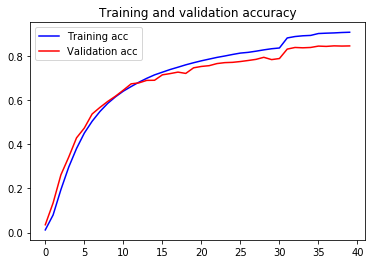

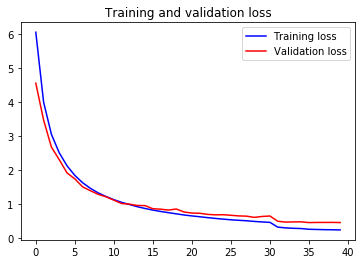

In [7]:
# Plot the accuracy and loss curves
acc = history_pre.history['acc']
val_acc = history_pre.history['val_acc']
loss = history_pre.history['loss']
val_loss = history_pre.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
# save class information

# Get the filenames from the generator
fnames = valid_generator.filenames
# Get the ground truth from generator
ground_truth = valid_generator.classes
# Get the label to class mapping from the generator
label2index = valid_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

with open("classes.csv", 'w', encoding="utf-8") as csvfile:
    for key in idx2label.keys():
        csvfile.write("%s,%s\n"%(key,idx2label[key]))

In [9]:
# Display inaccurate image

valid_generator2 = valid_datagen.flow_from_directory(
    directory=datapath + 'Validate\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=200,
    class_mode="categorical",
    shuffle=False
)

# Get the filenames from the generator
fnames = valid_generator2.filenames

# Get the ground truth from generator
ground_truth = valid_generator2.classes

# Get the label to class mapping from the generator
label2index = valid_generator2.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(valid_generator2, steps=valid_generator2.samples/valid_generator2.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),valid_generator2.samples))

# Show the errors
showErrImage = False
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    print(title)
    
    if showErrImage == True:
        original = load_img('{}/{}'.format(datapath + 'Validate\\',fnames[errors[i]]))
        plt.figure(figsize=[1,1])
        plt.axis('off')
        plt.imshow(original)
        plt.show()


Found 69400 images belonging to 347 classes.
347/347 [==============================] - 92s 266ms/step
No of errors = 10669/69400
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_0_0.png, Prediction :Microsoft_微软简中圆, confidence : 0.418
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_100_0.png, Prediction :HanYi_HYZhongYuanJ, confidence : 0.625
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_114_0.png, Prediction :Microsoft_微软简中圆, confidence : 0.508
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_125_0.png, Prediction :Microsoft_微软简中圆, confidence : 0.561
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_126_0.png, Prediction :Microsoft_微软简中圆, confidence : 0.573
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_13_0.png, Prediction :Microsoft_微软简中圆, confidence : 0.534
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_145_0.png, Prediction :Microsoft_微软简中圆, confidence : 0.486
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_156_0.png, Prediction :HanYi_HYZhongYuanJ, confidence : 0.507
Original label:ChuangYi_创艺简中圆\0_创艺简中圆_163_0.png, Prediction :Microsoft_微软简中圆, confidence : 

Original label:ChuangYi_创艺简隶书\0_创艺简隶书_872_0.png, Prediction :Microsoft_微软简隶书, confidence : 0.463
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_875_0.png, Prediction :HanYi_HYDaLiShuJ, confidence : 0.381
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_878_0.png, Prediction :Microsoft_微软简隶书, confidence : 0.546
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_879_0.png, Prediction :Microsoft_微软简隶书, confidence : 0.450
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_892_0.png, Prediction :Microsoft_微软简隶书, confidence : 0.525
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_895_0.png, Prediction :Microsoft_微软简隶书, confidence : 0.592
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_898_0.png, Prediction :Microsoft_微软简隶书, confidence : 0.627
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_907_0.png, Prediction :HanYi_HYDaLiShuJ, confidence : 0.422
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_910_0.png, Prediction :Microsoft_微软简隶书, confidence : 0.499
Original label:ChuangYi_创艺简隶书\0_创艺简隶书_915_0.png, Prediction :HanYi_HYDaLiShuJ, confidence : 0.387
Original label:ChuangYi_创艺简

Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_430_0.png, Prediction :HanYi_HYCuHeiJ, confidence : 0.644
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_463_0.png, Prediction :HanYi_HYChaoJiZhanJiaW, confidence : 0.262
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_475_0.png, Prediction :HanYi_HYCuHeiJ, confidence : 0.849
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_479_0.png, Prediction :HanYi_HYCuHeiJ, confidence : 0.960
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_513_0.png, Prediction :HanYi_HYCuHeiJ, confidence : 0.946
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_544_0.png, Prediction :HanYi_HYCuHeiJ, confidence : 0.955
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_580_0.png, Prediction :WenDing_文鼎特粗黑简, confidence : 0.605
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_624_0.png, Prediction :WenDing_文鼎特粗黑简, confidence : 0.802
Original label:HanYi_HYChaoCuHeiJ\0_HYChaoCuHeiJ_64_0.png, Prediction :WenDing_文鼎特粗黑简, confidence : 0.885
Original label:HanYi_HYChaoCuH

Original label:HanYi_HYJiaShuJ\0_HYJiaShuJ_296_0.png, Prediction :HanYi_HYXiYuanJ, confidence : 0.734
Original label:HanYi_HYJiaShuJ\0_HYJiaShuJ_422_0.png, Prediction :HanYi_HYZhangZiShanTiW, confidence : 0.689
Original label:HanYi_HYJiaShuJ\0_HYJiaShuJ_750_0.png, Prediction :HanYi_HYZhengYuan-35W, confidence : 0.690
Original label:HanYi_HYJiaShuJ\0_HYJiaShuJ_880_0.png, Prediction :HanYi_HYZhengYuan-35W, confidence : 0.332
Original label:HanYi_HYJiaShuJ\0_HYJiaShuJ_904_0.png, Prediction :HanYi_HYXiJianHeiJ, confidence : 0.730
Original label:HanYi_HYJiaShuJ\0_HYJiaShuJ_954_0.png, Prediction :WenDing_文鼎谁的字体简, confidence : 0.748
Original label:HanYi_HYJinChangTiJ\0_HYJinChangTiJ_20_0.png, Prediction :Microsoft_微软简魏碑, confidence : 0.468
Original label:HanYi_HYJinChangTiJ\0_HYJinChangTiJ_816_0.png, Prediction :HanYi_HYShenGongTiJ, confidence : 0.997
Original label:HanYi_HYJinKaiJ\0_HYJinKaiJ_262_0.png, Prediction :HanYi_HYDaShengTiJ, confidence : 0.350
Original label:HanYi_HYJinKaiJ\0_HYJin

Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_772_0.png, Prediction :HuaKang_DFPShaoNvW5-GB, confidence : 0.937
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_814_0.png, Prediction :HanYi_HYShiGuangTiW, confidence : 0.769
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_871_0.png, Prediction :HanYi_HYTangTangCuTiJ, confidence : 0.881
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_888_0.png, Prediction :HanYi_HYLiangPinXianCuJ, confidence : 0.625
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_901_0.png, Prediction :HanYi_HYLiangPinXianCuJ, confidence : 0.881
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_907_0.png, Prediction :HanYi_HYLiangPinXianCuJ, confidence : 0.940
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_922_0.png, Prediction :HanYi_HYLiangPinXianCuJ, confidence : 0.822
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_931_0.png, Prediction :HanYi_HYManBuTiJ, confidence : 0.914
Original label:HanYi_HYQingKongTiW\0_HYQingKongTiW_989_0.png, Predicti

Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_568_0.png, Prediction :HanYi_HYXingKaiJ, confidence : 0.340
Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_610_0.png, Prediction :HanYi_HYXuJingXingKaiW, confidence : 0.560
Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_611_0.png, Prediction :HanYi_HYGuoQiangXingShuW, confidence : 0.843
Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_62_0.png, Prediction :HanYi_HanyiSentyZhangjizhi, confidence : 0.474
Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_67_0.png, Prediction :HanYi_HYErMaMoShuW, confidence : 0.757
Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_682_0.png, Prediction :HanYi_SentyTriumphCalligraphy, confidence : 0.815
Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_687_0.png, Prediction :HanYi_SentyGoldenBell, confidence : 0.892
Original label:HanYi_HYSunWanMinCaoShuW\0_HYSunWanMinCaoShuW_730_0.png, Prediction :WenDing_文鼎行楷碑体简, confidence

Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_257_0.png, Prediction :WenDing_文鼎CS行楷简, confidence : 0.393
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_259_0.png, Prediction :ChuangYi_创艺简行楷, confidence : 0.277
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_268_0.png, Prediction :ChuangYi_创艺简行楷, confidence : 0.333
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_278_0.png, Prediction :WenDing_文鼎CS行楷简, confidence : 0.271
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_290_0.png, Prediction :ChuangYi_创艺简行楷, confidence : 0.464
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_292_0.png, Prediction :ChuangYi_创艺简行楷, confidence : 0.267
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_300_0.png, Prediction :WenDing_文鼎粗行楷简, confidence : 0.415
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_316_0.png, Prediction :WenDing_文鼎粗行楷简, confidence : 0.896
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_322_0.png, Prediction :HanYi_HYXuJingXingKaiW, confidence : 0.563
Original label:HanYi_HYXingKaiJ\0_HYXingKaiJ_333_0.png, Predict

Original label:HanYi_HYZhongSongJ\0_HYZhongSongJ_833_0.png, Prediction :WenDing_文鼎CS中宋简, confidence : 0.593
Original label:HanYi_HYZhongSongJ\0_HYZhongSongJ_878_0.png, Prediction :WenDing_文鼎CS中宋简, confidence : 0.629
Original label:HanYi_HYZhongSongJ\0_HYZhongSongJ_89_0.png, Prediction :WenDing_文鼎CS中宋简, confidence : 0.460
Original label:HanYi_HYZhongSongJ\0_HYZhongSongJ_900_0.png, Prediction :WenDing_文鼎CS中宋简, confidence : 0.519
Original label:HanYi_HYZhongSongJ\0_HYZhongSongJ_908_0.png, Prediction :HanYi_HYChangSongJ, confidence : 0.651
Original label:HanYi_HYZhongSongJ\0_HYZhongSongJ_945_0.png, Prediction :WenDing_文鼎大标宋简, confidence : 0.438
Original label:HanYi_HYZhongXiuTiJ\0_HYZhongXiuTiJ_267_0.png, Prediction :HanYi_HYCuJianHeiJ, confidence : 0.572
Original label:HanYi_HYZhongXiuTiJ\0_HYZhongXiuTiJ_444_0.png, Prediction :HanYi_HYChangYiTiJ, confidence : 0.890
Original label:HanYi_HYZhongXiuTiJ\0_HYZhongXiuTiJ_75_0.png, Prediction :HanYi_HYXiXiuTiJ, confidence : 0.916
Original label:

Original label:HanYi_HanyiSentyFlorCalligraphy\0_Hanyi Senty Floral Calligraphy_588_0.png, Prediction :HanYi_HanyiSentyYongleEncyclopedia, confidence : 0.774
Original label:HanYi_HanyiSentyFlorCalligraphy\0_Hanyi Senty Floral Calligraphy_594_0.png, Prediction :HanYi_SentyWEN, confidence : 0.500
Original label:HanYi_HanyiSentyFlorCalligraphy\0_Hanyi Senty Floral Calligraphy_616_0.png, Prediction :HanYi_SentyTriumphCalligraphy, confidence : 0.484
Original label:HanYi_HanyiSentyFlorCalligraphy\0_Hanyi Senty Floral Calligraphy_641_0.png, Prediction :HanYi_HanyiSentyYongleEncyclopedia, confidence : 0.424
Original label:HanYi_HanyiSentyFlorCalligraphy\0_Hanyi Senty Floral Calligraphy_697_0.png, Prediction :HanYi_HanyiSentyYongleEncyclopedia, confidence : 0.980
Original label:HanYi_HanyiSentyFlorCalligraphy\0_Hanyi Senty Floral Calligraphy_712_0.png, Prediction :HanYi_SentyWEN, confidence : 0.616
Original label:HanYi_HanyiSentyFlorCalligraphy\0_Hanyi Senty Floral Calligraphy_730_0.png, Predic

Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_234_0.png, Prediction :HanYi_SentyPea, confidence : 0.407
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_239_0.png, Prediction :WenDing_文鼎中行书简, confidence : 0.990
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_242_0.png, Prediction :HanYi_HanyiSentyLotus, confidence : 0.858
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_253_0.png, Prediction :HanYi_SentyMARUKO, confidence : 0.993
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_277_0.png, Prediction :HanYi_SentyTEA-Basic, confidence : 0.654
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_302_0.png, Prediction :HanYi_HanyiSentyMeadow, confidence : 0.414
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_328_0.png, Prediction :HanYi_SentyMARUKO, confidence : 0.683
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_342_0.png, Prediction :WenDing_文鼎谁的字体简, confidence : 0.797
Original label:HanYi_SentyTEA\0_SentyTEA 新蒂下午茶体_361_0.png, Prediction :HanYi_SentyTEA-Basic, confidence : 0.659
Original lab

Original label:Microsoft_微软vista仿宋\0_FangSong_325_0.png, Prediction :HanYi_HYFangSongS, confidence : 0.615
Original label:Microsoft_微软vista仿宋\0_FangSong_35_0.png, Prediction :HanYi_HYFangSongS, confidence : 0.803
Original label:Microsoft_微软vista仿宋\0_FangSong_369_0.png, Prediction :WenDing_文鼎CS仿宋体简, confidence : 0.870
Original label:Microsoft_微软vista仿宋\0_FangSong_396_0.png, Prediction :HanYi_HYChangLiSongKeBen(Original)W, confidence : 0.566
Original label:Microsoft_微软vista仿宋\0_FangSong_408_0.png, Prediction :HanYi_HYFangSongS, confidence : 0.870
Original label:Microsoft_微软vista仿宋\0_FangSong_459_0.png, Prediction :HanYi_HYFangSongS, confidence : 0.474
Original label:Microsoft_微软vista仿宋\0_FangSong_481_0.png, Prediction :HanYi_HYFangSongS, confidence : 0.582
Original label:Microsoft_微软vista仿宋\0_FangSong_483_0.png, Prediction :Microsoft_微软简仿宋, confidence : 0.328
Original label:Microsoft_微软vista仿宋\0_FangSong_49_0.png, Prediction :HanYi_HanyiSentyJoy, confidence : 0.923
Original label:Microso

Original label:Microsoft_微软简老宋\0_微软简老宋_51_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.668
Original label:Microsoft_微软简老宋\0_微软简老宋_52_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.484
Original label:Microsoft_微软简老宋\0_微软简老宋_534_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.572
Original label:Microsoft_微软简老宋\0_微软简老宋_550_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.639
Original label:Microsoft_微软简老宋\0_微软简老宋_556_0.png, Prediction :WenDing_文鼎大标宋简, confidence : 0.329
Original label:Microsoft_微软简老宋\0_微软简老宋_570_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.519
Original label:Microsoft_微软简老宋\0_微软简老宋_573_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.594
Original label:Microsoft_微软简老宋\0_微软简老宋_576_0.png, Prediction :WenDing_文鼎CS大宋, confidence : 0.289
Original label:Microsoft_微软简老宋\0_微软简老宋_578_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.615
Original label:Microsoft_微软简老宋\0_微软简老宋_582_0.png, Prediction :ChuangYi_创艺简老宋, confidence : 0.473
Original label:Microsoft_微软简老宋\0

Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_698_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.685
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_746_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.843
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_752_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.792
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_753_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.545
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_781_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.824
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_790_0.png, Prediction :HanYi_HYJunHei-35W, confidence : 0.473
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_837_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.704
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_841_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.532
Original label:WenDing_文鼎CS中等线简\0_文鼎CS中等線_842_0.png, Prediction :HanYi_HYZhongDengXianS, confidence : 0.731
Original label:WenDing_文鼎CS中等线简\

Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_560_0.png, Prediction :HanYi_HYXingKaiJ, confidence : 0.717
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_567_0.png, Prediction :ChuangYi_创艺简行楷, confidence : 0.467
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_572_0.png, Prediction :HanYi_HYXingKaiJ, confidence : 0.330
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_579_0.png, Prediction :Microsoft_微软简行楷, confidence : 0.458
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_57_0.png, Prediction :ChuangYi_创艺简行楷, confidence : 0.247
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_584_0.png, Prediction :HanYi_HYXingKaiJ, confidence : 0.565
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_585_0.png, Prediction :HanYi_HYXingKaiJ, confidence : 0.440
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_587_0.png, Prediction :WenDing_文鼎粗行楷简, confidence : 0.495
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_589_0.png, Prediction :HanYi_SentyZHAO, confidence : 0.956
Original label:WenDing_文鼎CS行楷简\0_文鼎CS行楷_594_0.png, Prediction :ChuangYi_创艺简行楷, confidence : 0.290
Original la

Original label:WenDing_文鼎淹水体简\0_文鼎淹水体_904_0.png, Prediction :WenDing_文鼎竹子体简, confidence : 0.372
Original label:WenDing_文鼎潇洒体简\0_文鼎潇洒体_151_0.png, Prediction :HanYi_HYErMaMoShuW, confidence : 0.850
Original label:WenDing_文鼎潇洒体简\0_文鼎潇洒体_257_0.png, Prediction :HanYi_HYTianXinTiW, confidence : 0.930
Original label:WenDing_文鼎潇洒体简\0_文鼎潇洒体_431_0.png, Prediction :HanYi_HYBoJingTiJ, confidence : 0.943
Original label:WenDing_文鼎潇洒体简\0_文鼎潇洒体_933_0.png, Prediction :HanYi_HYShangWeiLiuYunTiW, confidence : 0.928
Original label:WenDing_文鼎潇洒体简\0_文鼎潇洒体_973_0.png, Prediction :WenDing_文鼎中特广告体简, confidence : 0.459
Original label:WenDing_文鼎火柴体简\0_Arphic Huochai-Bold-GB_548_0.png, Prediction :WenDing_文鼎弹簧体简, confidence : 0.551
Original label:WenDing_文鼎火柴体简\0_Arphic Huochai-Bold-GB_829_0.png, Prediction :HanYi_HYShuiDiTiJ, confidence : 0.737
Original label:WenDing_文鼎火柴体简\0_Arphic Huochai-Bold-GB_852_0.png, Prediction :HanYi_HYAlzheimer, confidence : 0.451
Original label:WenDing_文鼎火柴体简\0_Arphic Huochai-Bold-GB_

In [10]:
img = Image.open('D:\\FontImageGenerator\\TextImageGenerator\\TextImageGenerator\\bin\\Release\\Output\\Test\\Test_folder\\0_HYYuanTiLiShuW_96_5.png').convert('RGB')
nimg = np.asarray(img)
#print(nimg.shape)
plt.imshow(img)

imarray = preprocess_input(np.array([nimg]))
#print(imarray.shape)

cls = model.predict_classes(imarray)


print(idx2label[cls[0]])




FileNotFoundError: [Errno 2] No such file or directory: 'D:\\FontImageGenerator\\TextImageGenerator\\TextImageGenerator\\bin\\Release\\Output\\Test\\Test_folder\\0_HYYuanTiLiShuW_96_5.png'